<a href="https://colab.research.google.com/github/Priom7/ML/blob/main/Rice_Type_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [90]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [114]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
# print(data_df.head())
# print(data_df.shape)
# print(data_df.info())
data_df.drop(['id'], axis=1, inplace= True)
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [115]:
original_df = data_df.copy()
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [116]:
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [117]:

X = np.array(data_df.iloc[:, :-1])
# print(X.shape, data_df.iloc[:, :-1].head)
y = np.array(data_df.iloc[:, -1])
# print(data_df.iloc[:, -1].head)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size= 0.5)

In [96]:
print("Train Set: ", X_train.shape[0], " and " , round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation Set: ", X_val.shape[0], " and ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Test Set: ", X_test.shape[0], " and ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Train Set:  12729  and  70.0 %
Validation Set:  2728  and  15.0 %
Test Set:  2728  and  15.0 %


In [118]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.y = torch.tensor(y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [119]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [120]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size = BATCH_SIZE, shuffle= True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)



In [121]:
class RiceClassifier(nn.Module):
  def __init__(self):

    super(RiceClassifier, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.liear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.liear(x)
    x = self.sigmoid(x)
    return x

In [122]:
rice_classifire_model = RiceClassifier().to(device)
summary(rice_classifire_model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [123]:
criterion = nn.BCELoss()
optimizer = Adam(rice_classifire_model.parameters(), lr = LR)


In [124]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [126]:
for epoch in range(EPOCHS):
  total_acc_train =0
  total_loss_train = 0
  total_acc_val =0
  total_loss_val =0

  for data in train_dataloader:
    inputs, lables = data

    prediction = rice_classifire_model(inputs).squeeze(1)

    batch_loss = criterion(prediction, lables)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == lables).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:

      input, labels = data

      prediction = rice_classifire_model(inputs).squeeze(1)

      batch_loss = criterion(prediction, lables)

      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == lables).sum().item()

      total_acc_val += acc


  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
  print("="*50)





Epoch no. 1 Train Loss: 0.0499 Train Accuracy: 98.4288 Validation Loss: 0.0083 Validation Accuracy: 78.8123
Epoch no. 2 Train Loss: 0.0333 Train Accuracy: 98.5073 Validation Loss: 0.0078 Validation Accuracy: 75.6598
Epoch no. 3 Train Loss: 0.0260 Train Accuracy: 98.6173 Validation Loss: 0.0036 Validation Accuracy: 78.8123
Epoch no. 4 Train Loss: 0.0223 Train Accuracy: 98.6488 Validation Loss: 0.0014 Validation Accuracy: 78.8123
Epoch no. 5 Train Loss: 0.0200 Train Accuracy: 98.6566 Validation Loss: 0.0034 Validation Accuracy: 78.8123
Epoch no. 6 Train Loss: 0.0187 Train Accuracy: 98.7273 Validation Loss: 0.0016 Validation Accuracy: 78.8123
Epoch no. 7 Train Loss: 0.0177 Train Accuracy: 98.6645 Validation Loss: 0.0009 Validation Accuracy: 78.8123
Epoch no. 8 Train Loss: 0.0171 Train Accuracy: 98.7116 Validation Loss: 0.0032 Validation Accuracy: 78.8123
Epoch no. 9 Train Loss: 0.0167 Train Accuracy: 98.6959 Validation Loss: 0.0008 Validation Accuracy: 78.8123
Epoch no. 10 Train Loss: 0.0

In [127]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in test_dataloader:
    inputs, lables = data

    prediction = rice_classifire_model(inputs).squeeze(1)

    batch_loss  = criterion(prediction, lables)

    total_loss_test += batch_loss.item()

    acc = ((prediction).round()== lables).sum().item()

    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.83%


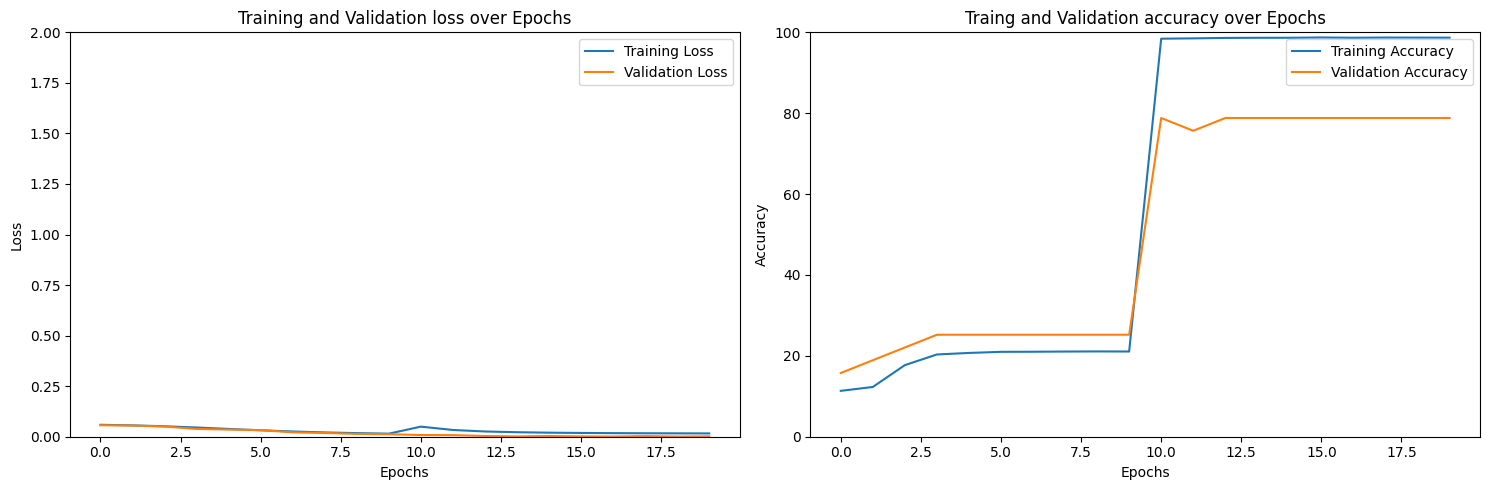

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label= "Training Loss")
axs[0].plot(total_loss_validation_plot, label= "Validation Loss")
axs[0].set_title('Training and Validation loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label= "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label= "Validation Accuracy")
axs[1].set_title('Traing and Validation accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()




